In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from keras.layers import Input, Dense, Flatten, Dropout, Activation, Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.models import Model, model_from_json
from keras.regularizers import l2, activity_l2
from keras.callbacks import ReduceLROnPlateau

#Preprocessing of the images
input_data = pd.read_csv('MINST/train.csv')
raw_images = input_data.iloc[:,1:].values
raw_images = raw_images.astype(np.float)

#Convert from [0:255] => [0.0:1.0]
norm_images = np.multiply(raw_images, 1.0 / 255.0)

In [ ]:
#Images are stored as 1-D vector
print norm_images.shape

In [ ]:
#Resize input images to ROWS X COLUMNS format to be used as input for a Convolution2D
ROWS = 28
COLUMNS = 28
resized_images = []
for k in range(0,norm_images.shape[0]):
    resized_images.append(norm_images[k].reshape(ROWS,COLUMNS,1))
resized_images = np.array(resized_images)
print resized_images.shape

In [ ]:
#Test of a random resized image
#plt.axis('off')
#plt.imshow(resized_images[1], cmap=cm.binary)
#plt.show()

In [ ]:
#Preprocessing of the labels
raw_labels = input_data.iloc[:,0].values
raw_labels = raw_labels.astype(np.float)

print raw_labels.shape

In [ ]:
#Example of one of the labels and the maximum and minimum
print raw_labels[1]
print np.amax(raw_labels)
print np.amin(raw_labels)

In [7]:
#Convert labels into vector of categories. Class 0 = digit 0... class 9 = digi9
nb_classes = 10
cat_labels = np_utils.to_categorical(raw_labels, nb_classes)
print cat_labels[1]


# Splitting between training and validation

In [8]:
#Shuffling dataset and splling between training and validation with fraction train_frac
from sklearn.utils import shuffle
shuffled_resized_images, shuffled_cat_labels = shuffle(resized_images, cat_labels, random_state=0)
train_frac = 0.99

Xtrain = shuffled_resized_images[1:int(shuffled_resized_images.shape[0]*train_frac)]
Ytrain = shuffled_cat_labels[1:int(shuffled_resized_images.shape[0]*train_frac)]

Xval = shuffled_resized_images[Xtrain.shape[0]:]
Yval = shuffled_cat_labels[Ytrain.shape[0]:]


print Xtrain.shape
print Ytrain.shape
print Xval.shape
print Yval.shape
print Xtrain.shape[0]+Xval.shape[0]

(41579, 28, 28, 1)
(41579, 10)
(421, 28, 28, 1)
(421, 10)
42000


# ConvNN architecture

In [9]:
#Model Parameters
batch_size = 32 # in each iteration, we consider batch_size training examples at once
num_epochs = 60 # we iterate n_epoch times over the entire training set
kernel_size = 3 # we will use kernel_size x kernel_size filters throughout
pool_size = 2 # we will use 2x2 (max)pooling throughout
conv_depth_1 = 32 # we will initially have 32 kernels per conv. layer...
conv_depth_2 = 64 # ...switching to 64 after the first pooling layer
conv_depth_3 = 128 # ...switching to 64 after the second pooling layer
drop_prob_1 = 0.25 # dropout after pooling with probability 0.25
drop_prob_2 = 0.5 # dropout in the FC layer with probability 0.5
hidden_size = 32 # the FC layer will have hidden_size neurons
data_augmentation = False # Whether to use or not data augmentation

#Architecture
inp = Input(shape=(ROWS, COLUMNS,1)) 
# Conv [32] -> Conv [32] -> Pool (with dropout on the pooling layer)
#conv_1 = Convolution2D(conv_depth_1, kernel_size, kernel_size, border_mode='same', activation='relu')(inp)
conv_1 = Convolution2D(conv_depth_1, kernel_size, kernel_size, border_mode='same', activation='relu')(inp)
pool_1 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_1)
drop_1 = Dropout(drop_prob_1)(pool_1)
conv_2 = Convolution2D(conv_depth_2, kernel_size, kernel_size, border_mode='same', activation='relu')(drop_1)
pool_2 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_2)
conv_3 = Convolution2D(conv_depth_3, kernel_size, kernel_size, border_mode='same', activation='relu')(pool_2)
#drop_1 = Dropout(drop_prob_1)(pool_1)
# Conv [64] -> Conv [64] -> Pool (with dropout on the pooling layer)
#conv_3 = Convolution2D(conv_depth_2, kernel_size, kernel_size, border_mode='same', activation='relu')(drop_1)
#conv_4 = Convolution2D(conv_depth_2, kernel_size, kernel_size, border_mode='same', activation='relu')(conv_3)
#pool_2 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_4)
#drop_2 = Dropout(drop_prob_1)(pool_2)
# Now flatten to 1D, apply FC -> ReLU (with dropout) -> softmax
#flat = Flatten()(drop_2)
flat = Flatten()(pool_2)
hidden = Dense(hidden_size, activation='relu')(flat)
#hidden = Dense(hidden_size, W_regularizer=l2(0.01), activity_regularizer=activity_l2(0.01), activation='relu')(flat)
drop_1 = Dropout(drop_prob_1)(hidden)
#out = Dense(num_classes, activation='softmax')(drop_3)
out = Dense(nb_classes, activation='softmax')(hidden)
model = Model(input=inp, output=out) # To define a model, just specify its input and output layers

#print the summary of the architecture
model.summary()

#Visulize the model if desired
from keras.utils.visualize_util import plot
plot(model, to_file='Example_of_CNN_MINST.pdf')

# reduce the learning rate by factor of 0.5 if the validation loss does not get lower in 7 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=0.0000001, verbose=1)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 28, 28, 32)    320         input_1[0][0]                    
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 14, 14, 32)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 14, 14, 32)    0           maxpooling2d_1[0][0]             
___________________________________________________________________________________________

In [10]:
# Let's train the model using SGD without data augmentation
#model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
#For future testing...
#model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy']) 
#model.compile(loss='categorical_crossentropy', optimizer='rmpsprop', metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])


# Let's train the SGD model WITHOUT using data augmentation
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(Xtrain, Ytrain, batch_size=batch_size, nb_epoch=num_epochs,
          validation_data=(Xval, Yval), shuffle=True, callbacks=[reduce_lr])

# Let's train the SGD model using data augmentation
else:
    print('Using real-time data augmentation.')
    #See http://machinelearningmastery.com/image-augmentation-deep-learning-keras/ for the infividual
    #effects of each parameter in ImageDataGenerator
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=True, # apply ZCA whitening
        #zoom_range=0.1
        #Not really needed for MINST because images are centerd
        #rotation_range=20,   
        #width_shift_range=0.2,
        #height_shift_range=0.2,
    )
    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(Xtrain)
    
    # Fit the model on the batches generated by datagen.flow().
    history = model.fit_generator(datagen.flow(Xtrain, Ytrain,
                        batch_size=batch_size),
                        samples_per_epoch=Xtrain.shape[0], #For each epoch generate Xtrain.shape[0] new images for training
                        nb_epoch=num_epochs,
                        validation_data=(Xval, Yval),
                        #validation_data=(Xtrain, Ytrain),
                        callbacks=[reduce_lr]
                       )

Not using data augmentation.
Train on 41579 samples, validate on 421 samples
Epoch 1/60
41579/41579 [==============================] - 84s - loss: 0.1928 - acc: 0.9414 - val_loss: 0.1042 - val_acc: 0.9715
Epoch 2/60
41579/41579 [==============================] - 86s - loss: 0.0790 - acc: 0.9766 - val_loss: 0.0880 - val_acc: 0.9691
Epoch 3/60
41579/41579 [==============================] - 81s - loss: 0.0634 - acc: 0.9810 - val_loss: 0.0659 - val_acc: 0.9739
Epoch 4/60
41579/41579 [==============================] - 85s - loss: 0.0543 - acc: 0.9838 - val_loss: 0.0581 - val_acc: 0.9739
Epoch 5/60
41579/41579 [==============================] - 85s - loss: 0.0478 - acc: 0.9848 - val_loss: 0.0611 - val_acc: 0.9786
Epoch 6/60
41579/41579 [==============================] - 90s - loss: 0.0445 - acc: 0.9863 - val_loss: 0.0550 - val_acc: 0.9762
Epoch 7/60
41579/41579 [==============================] - 86s - loss: 0.0416 - acc: 0.9876 - val_loss: 0.0477 - val_acc: 0.9810
Epoch 8/60
41579/41579 [===

# Record
Best acc in validation set is 0.9855 and train 0.9910

# Learning rate

['acc', 'loss', 'val_acc', 'val_loss', 'lr']


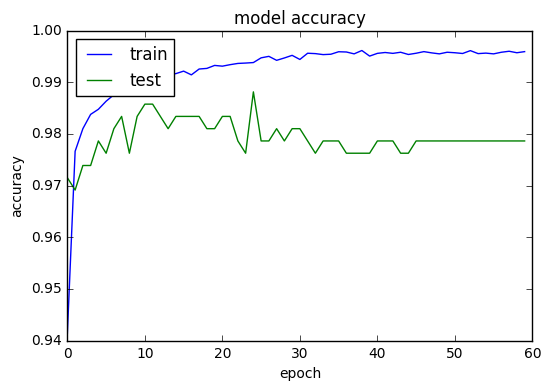

In [11]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('Accuracy_MINST.pdf')
plt.close()

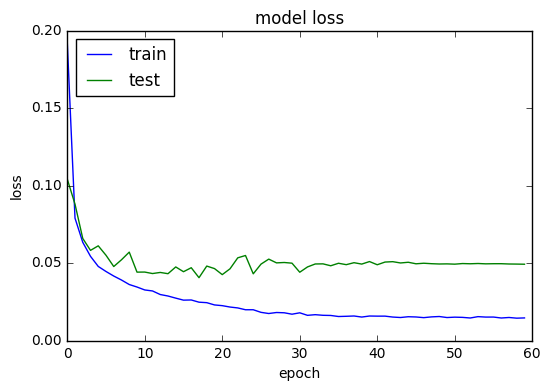

In [12]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('Loss_MINST.pdf')
plt.close()

# Save the trained model for future usage

In [13]:
# serialize model to JSON
model_json = model.to_json()
with open("Example_ConvNN_MINST.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("Example_ConvNN_MINST.h5")
print("Saved model to disk")

Saved model to disk


# Load the model and re-test the performance in train and validation datasets

In [14]:
# load json and create model
json_file = open("Example_ConvNN_MINST.json", "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("Example_ConvNN_MINST.h5")
print("Loaded model from disk")
 
# evaluate loaded model on  data
loaded_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
score_train = loaded_model.evaluate(Xtrain, Ytrain, verbose=0)
score_val = loaded_model.evaluate(Xtrain, Ytrain, verbose=0)
print "%s: %.2f%%" % (loaded_model.metrics_names[1], score_train[1]*100)
print "%s: %.2f%%" % (loaded_model.metrics_names[1], score_val[1]*100)

Loaded model from disk
acc: 99.75%
acc: 99.75%


# Predictions in new and unlabelled data

In [15]:
#Preprocessing of the images
test_data = pd.read_csv('MINST/test.csv')
test_images = test_data.iloc[:,:].values
test_images = test_images.astype(np.float)

#Convert from [0:255] => [0.0:1.0]
norm_test_images = np.multiply(test_images, 1.0 / 255.0)
print norm_test_images.shape

#Resize input images to ROWS X COLUMNS format to be used as input for a Convolution2D
resized_test_images = []
for k in range(0,norm_test_images.shape[0]):
    resized_test_images.append(norm_test_images[k].reshape(ROWS,COLUMNS,1))
resized_test_images = np.array(resized_test_images)
print resized_test_images.shape

#Make predictions
test_pred_prob = model.predict(resized_test_images)
print test_pred_prob.shape
print test_pred_prob[0]

#Select the classes with highest probabilities as class predictions
test_pred = np.argmax(test_pred_prob, axis=1)
print test_pred[0]

#Save the predictions
from datetime import datetime
np.savetxt('mnist-predictions-ConvNN%s.csv' % datetime.now().strftime('%Y-%m-%d_%H%M'), np.c_[range(1, len(test_pred) + 1), test_pred], delimiter = ',', header = 'ImageId,Label', comments = '', fmt='%d')
print("Predictions Ready")

(28000, 784)
(28000, 28, 28, 1)
(28000, 10)
[  6.86090004e-11   4.70638314e-15   1.00000000e+00   3.38862029e-11
   1.98752297e-16   1.51582285e-15   3.06457740e-18   1.72751158e-12
   1.44540456e-11   1.10632613e-13]
2
Predictions Ready
